In [1]:
import numpy as np
import scipy
from scipy.stats import multivariate_normal, wishart
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from problem1 import *

In [2]:
dat = pd.read_csv("Y.csv", header=None)


In [3]:
Y = dat.to_numpy()
Y.shape

(500, 2)

## Question 2

Similar to Question 1 in structure:

For each datum, we need to know which cluster it belongs to.

For each table, we need to be able to remove a datum and add datum easily.

Each table is associated with the hyperparameters of Normal-Wishart.

\begin{align}
    y_i | z_i, \theta &\sim \text{Normal}(\mu_{z_i}, \Gamma_{z_i}^{-1}) \\
    \mu_k, \Gamma_{k} &\sim \text{NormalWishart}(\boldsymbol{\mu}_0, \kappa_0, \nu_0, V_0).
\end{align}

We choose $\boldsymbol{\mu}_0 = 0$, $\kappa_0 = 1$, $\nu = 2$, and $V0 = I$.

With the above choices, the hyper-parameters update for cluster $k$ with $n$ data points,

\begin{align*}
    \kappa_k &= \kappa_0 + n \\
    \boldsymbol{\mu}_{0,k} &= \frac{\kappa_0 \boldsymbol{\mu}_0 +  n \bar{y}_k}{\kappa_0 + n} \\
    \nu_k &= \nu_0 + n \\
    V_k &= \left( V^{-1} + \sum_{i : z_i = k} (y_i - \bar{y}_k) (y_i - \bar{y}_k)^T + \frac{\kappa_0 n}{\kappa_0 + n} (\bar{y}_k - \boldsymbol{\mu}_0)(\bar{y}_k - \boldsymbol{\mu}_0)^T \right)^{-1}.
\end{align*}

To facilitate efficient computation, we can track summary statistics for each cluster $k$:

\begin{align}
    \tilde{y}_{k,1} &= \sum_{i : z_i = k} y_i \\
    \tilde{y}_{k,2} &= \sum_{i : z_i = k} y_i y_i^T.\\
\end{align}

Given these summary statistics, we can readily compute the NW parameters. And when we add a new datum to cluster $k$, updating these summary stats is simple.


In [4]:
# Hyper parameters
dp_concentration = 1.0
dim = 2
ident = np.diag(np.ones(dim))
prior_params = {"mu0": np.zeros(dim), "kappa0": 1., "nu0": dim, "V0": ident}
N = Y.shape[0]
gibbs_iter = 100

In [5]:
states = algorithm3(Y, dp_concentration, prior_params, gibbs_iter)

Assign datum: 164 to new cluster
Assign datum: 475 to new cluster
Number of cluster: 3
Total data: 500
Current log likelihood: -6388.345757437483
Assign datum: 13 to new cluster
Assign datum: 48 to new cluster
Assign datum: 74 to new cluster
Assign datum: 401 to new cluster
Assign datum: 483 to new cluster
Number of cluster: 8
Total data: 500
Current log likelihood: -5893.547729520586
Assign datum: 126 to new cluster
Number of cluster: 5
Total data: 500
Current log likelihood: -5549.365319868064
Assign datum: 483 to new cluster
Number of cluster: 5
Total data: 500
Current log likelihood: -5005.010194151013
Number of cluster: 3
Total data: 500
Current log likelihood: -4690.3722100407795
Number of cluster: 3
Total data: 500
Current log likelihood: -4654.226768667235
Number of cluster: 3
Total data: 500
Current log likelihood: -4655.823122394195
Number of cluster: 3
Total data: 500
Current log likelihood: -4656.457689916733
Number of cluster: 3
Total data: 500
Current log likelihood: -465

In [44]:
z = states[-1].astype(int)
cl_ids, cl_counts = np.unique(z, return_counts=True)
print(cl_ids)
print(cl_counts)
z.shape

[0 1 2 3 4 5]
[295   5  53 145   1   1]


(500,)

In [64]:
# Estimate covariance matrix.
def posterior_normal_params(Y_k, n, prior_params):
    sum_y = Y_k.sum(axis=0)
    sum_y_sq = Y_k.T @ Y_k
    y_bar = sum_y / n
    dim = Y_k.shape[1]
    mu0 = prior_params["mu0"]
    k0 = prior_params["kappa0"]
    nu0 = prior_params["nu0"]
    V0 = prior_params["V0"]
    
    k_n = k0 + n
    nu_n = nu0 + n
    
    mu_n = (k0 * mu0 + sum_y)/k_n
    scatter_term = sum_y_sq - n * np.outer(y_bar, y_bar)
    mean_term = (k0 * n) / (k0 + n) * np.outer(y_bar - mu0, y_bar - mu0)
    V_n = V0 + scatter_term + mean_term
    #Sigma_n = np.linalg.inv(k_n * V_n)
    Sigma_n = V_n/k_n
    return mu_n, Sigma_n


In [65]:
posterior_params = []
for k in cl_ids:
    Y_k = Y[z == k,:]
    n = Y_k.shape[0]
    mu_n, Sigma_n = posterior_normal_params(Y_k, n, prior_params)
    posterior_params.append({"mu": mu_n, "Sigma": Sigma_n, "n_points": n})
    print(f"Cluster {k}: {n} data points.")

Cluster 0: 295 data points.
Cluster 1: 5 data points.
Cluster 2: 53 data points.
Cluster 3: 145 data points.
Cluster 4: 1 data points.
Cluster 5: 1 data points.


In [66]:
posterior_params

[{'mu': array([0.9047303 , 3.29417515]),
  'Sigma': array([[0.31693077, 0.15036125],
         [0.15036125, 0.57938844]]),
  'n_points': 295},
 {'mu': array([0.51984827, 1.48794932]),
  'Sigma': array([[0.51163551, 0.19368776],
         [0.19368776, 1.00179675]]),
  'n_points': 5},
 {'mu': array([-3.45824398,  0.85359541]),
  'Sigma': array([[0.90770025, 0.54934427],
         [0.54934427, 1.89022304]]),
  'n_points': 53},
 {'mu': array([-1.81082728, -1.61848488]),
  'Sigma': array([[0.21215194, 0.12079933],
         [0.12079933, 0.43931317]]),
  'n_points': 145},
 {'mu': array([-0.2117636,  0.384638 ]),
  'Sigma': array([[ 0.54484382, -0.08145233],
         [-0.08145233,  0.64794639]]),
  'n_points': 1},
 {'mu': array([-0.05463851,  1.20407544]),
  'Sigma': array([[ 0.50298537, -0.06578889],
         [-0.06578889,  1.94979768]]),
  'n_points': 1}]

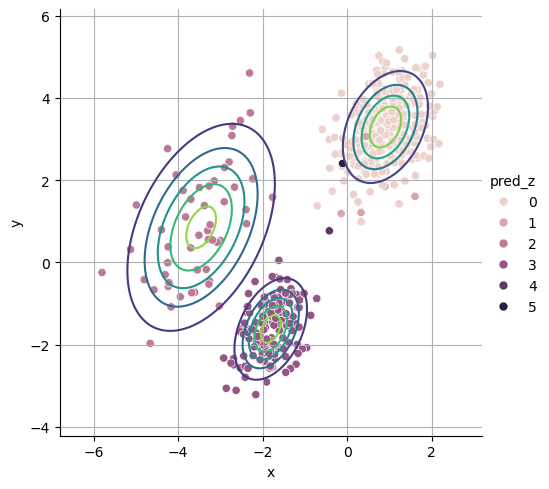

In [68]:
x_min = np.min(Y[:,0]) - 1
x_max = np.max(Y[:,0]) + 1
y_min = np.min(Y[:,1]) - 1
y_max = np.max(Y[:,1]) + 1
x, y = np.mgrid[x_min:x_max:.01, y_min:y_max:.01]
pos = np.dstack((x, y))

dat = pd.DataFrame({"x": Y[:,0], "y": Y[:,1], "pred_z": z})
g = sns.relplot(data=dat, x="x", y="y", hue="pred_z")
# Calculate the density values
for k in cl_ids:
    if posterior_params[k]["n_points"] > 5:
        rv = multivariate_normal(posterior_params[k]["mu"], posterior_params[k]["Sigma"])
        zz = rv.pdf(pos)
        plt.contour(x, y, zz, levels=5, linewidths=1.5, alpha=1, cmap='viridis')

plt.xlabel('x')
plt.ylabel('y')

plt.grid(True)
plt.show()
#plt.savefig("pml-a3/problem1_q1_example_fig.png")